In [1]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import imghdr
import seaborn as sns
from sklearn.utils import shuffle
plt.style.use('dark_background')

2024-08-21 16:39:35.300908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 16:39:35.301057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 16:39:35.477587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**_Checking Format_**

In [2]:
!cp -r /kaggle/input/dataset/Teeth_Dataset /kaggle/working/



In [3]:
!rm -r /kaggle/working/Teeth_Dataset/Testing/out
!rm -r /kaggle/working/Teeth_Dataset/Testing/output
!rm -r /kaggle/working/Teeth_Dataset/Testing/outputs
!rm  /kaggle/working/Teeth_Dataset/Testing/output_image.jpg

In [4]:
data_dir = "/kaggle/working/Teeth_Dataset"

Types = list(os.listdir(data_dir))
Illness=list(os.listdir(os.path.join(data_dir,Types[2])))
print(Types)
print(Illness)
print(len(os.listdir(os.path.join(data_dir,Types[2],Illness[1]))))


['Training', 'Testing', 'Validation']
['OC', 'Gum', 'CoS', 'OT', 'OLP', 'CaS', 'MC']
120


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


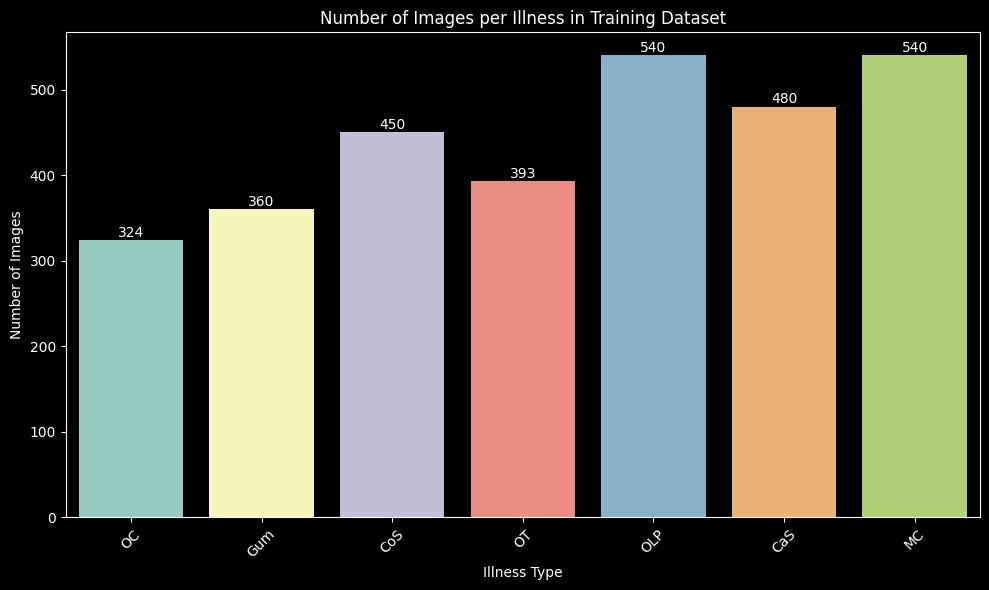

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


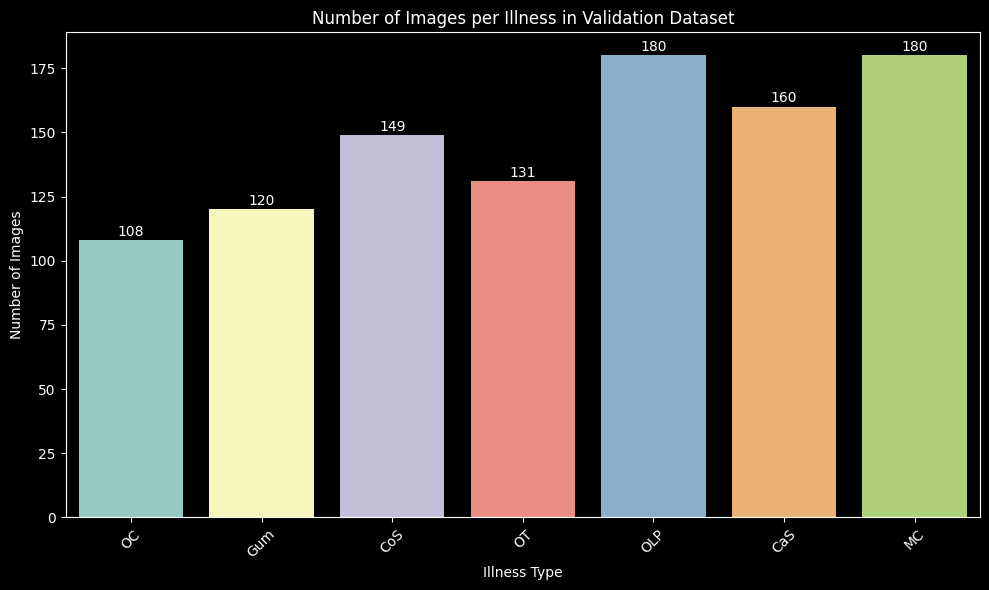

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


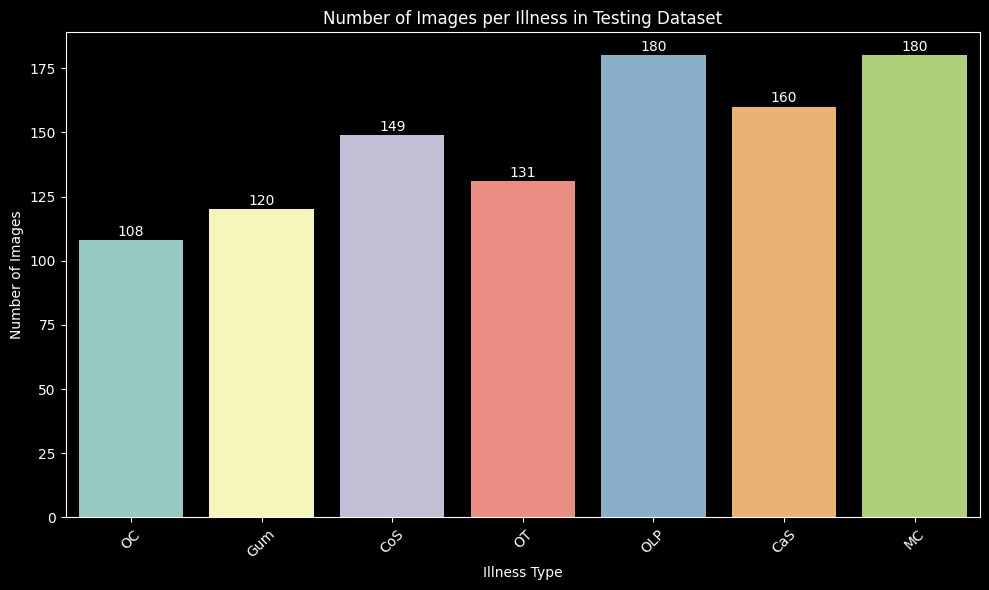

In [5]:
def plot_len_dir(index):
    global Types
    global Illness
    global data_dir
    illness_names = []
    illness_counts = []
    Target = os.path.join(data_dir, Types[index])
    for illness in Illness:
        illness_path = os.path.join(Target, illness)
        num_files = len(os.listdir(illness_path))
        illness_names.append(illness)
        illness_counts.append(num_files)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=illness_names, y=illness_counts, palette="Set3")

    plt.title(f"Number of Images per Illness in {Types[index]} Dataset")
    plt.xlabel("Illness Type")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)

    for index, value in enumerate(illness_counts):
        plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
plot_len_dir(0)
plot_len_dir(2)
plot_len_dir(1)

In [6]:
def check_format():
  global data_dir
  global Types
  global Illness
  counter=0
  allowed=['jpeg','jpg', 'bmp', 'png']
  for sample_Type in Types:
    for sample_Illness in Illness:
      for image in os.listdir(os.path.join(data_dir, sample_Type, sample_Illness)):
        image_path = os.path.join(data_dir, sample_Type, sample_Illness, image)
        try:
          img = cv.imread(image_path)
          if img is None:
                 raise ValueError(f"Image could not be read: {image_path}")

                 actual_format = imghdr.what(image_path)
                 if actual_format not in allowed:
                        print(f"Image not in ext list {image_path} (Detected: {actual_format})")
                        os.remove(image_path)
                        counter += 1
        except Exception as e:
          print(f'Issue with image {image_path}')
  print(counter)
check_format()



0


**_See our Data_**

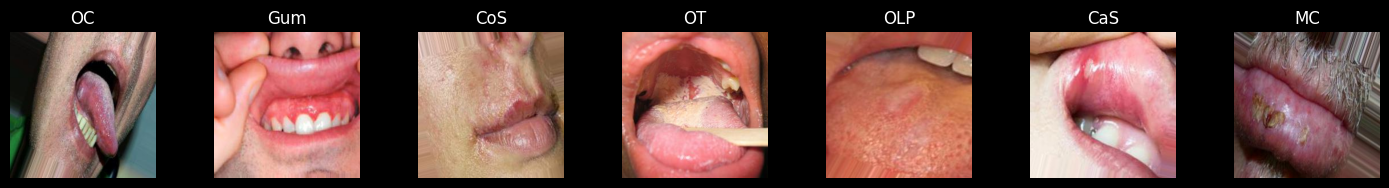

<Figure size 640x480 with 0 Axes>

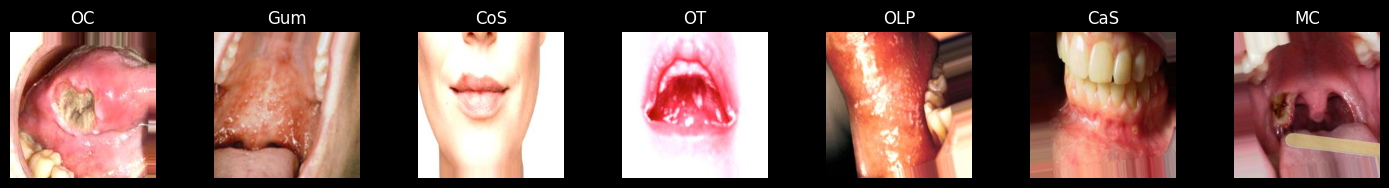

<Figure size 640x480 with 0 Axes>

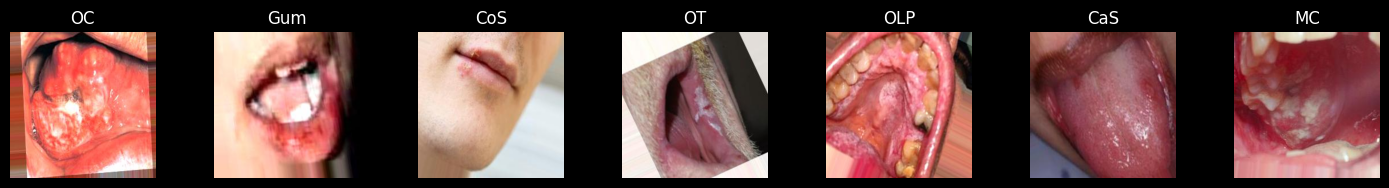

Text(0.5, 1.05, 'Random Images from Test Dataset')

<Figure size 640x480 with 0 Axes>

In [7]:
def plot_one_image_per_illness(category, illness_list):
    global data_dir
    plt.figure(figsize=(14, 7))

    for idx, illness in enumerate(illness_list):
        illness_dir = os.path.join(data_dir, category, illness)

        illness_images = [img for img in os.listdir(illness_dir) if img.endswith(('jpeg', 'jpg', 'bmp', 'png'))]
        if not illness_images:
            continue

        random_image = random.choice(illness_images)
        image_path = os.path.join(illness_dir, random_image)
        img = plt.imread(image_path)

        plt.subplot(1, len(illness_list), idx + 1)
        plt.imshow(img)
        plt.title(illness)

        plt.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.4)
    plt.show()
plot_one_image_per_illness(Types[0], Illness)
plt.suptitle('Random Images from Training Dataset', y=1.05)
plot_one_image_per_illness(Types[2], Illness)
plt.suptitle('Random Images from Validation Dataset', y=1.05)
plot_one_image_per_illness(Types[1], Illness)
plt.suptitle('Random Images from Test Dataset', y=1.05)


/kaggle/working/Teeth_Dataset/Testing/OC/oc_1210.jpg


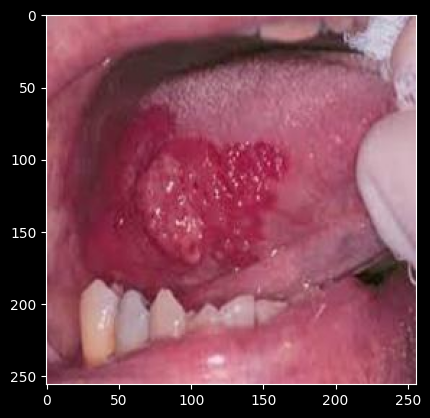

In [8]:
images_in_training=list(os.listdir(os.path.join(data_dir,Types[1],Illness[0])))
path=os.path.join(data_dir,Types[1],Illness[0],images_in_training[34])
print(path)
img=cv.cvtColor(cv.imread(path),cv.COLOR_BGR2RGB)
plt.imshow(img)

In [9]:
print(cv.imread)  # This should be a function, not a string or other type
print(type(cv.imread))

<built-in function imread>
<class 'builtin_function_or_method'>


# **_Preparing and Scalling Our Dataset_**

In [10]:
def list_to_dict(lst):
    return {item: index for index, item in enumerate(lst)}


label_map = list_to_dict(Illness)
print(label_map)

def load_images_from_directory(directory):
    images = []
    labels = []
    global Types
    global Illness
    global data_dir
    global label_map
    Catogry_path=os.path.join(data_dir,directory)
    for class_name in Illness:
        class_dir = os.path.join(Catogry_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        print(class_dir)
        for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                image = cv.imread(image_path)
                if image is not None:
                    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)  # Convert to RGB
                    images.append(image)
                    labels.append(label_map[class_name])
    return images, labels
Training_images, Training_labels=load_images_from_directory(Types[0])
Testing_images, Testing_labels=load_images_from_directory(Types[2])
Validation_images, Validation_labels=load_images_from_directory(Types[1])


{'OC': 0, 'Gum': 1, 'CoS': 2, 'OT': 3, 'OLP': 4, 'CaS': 5, 'MC': 6}
/kaggle/working/Teeth_Dataset/Training/OC
/kaggle/working/Teeth_Dataset/Training/Gum
/kaggle/working/Teeth_Dataset/Training/CoS
/kaggle/working/Teeth_Dataset/Training/OT
/kaggle/working/Teeth_Dataset/Training/OLP
/kaggle/working/Teeth_Dataset/Training/CaS
/kaggle/working/Teeth_Dataset/Training/MC
/kaggle/working/Teeth_Dataset/Validation/OC
/kaggle/working/Teeth_Dataset/Validation/Gum
/kaggle/working/Teeth_Dataset/Validation/CoS
/kaggle/working/Teeth_Dataset/Validation/OT
/kaggle/working/Teeth_Dataset/Validation/OLP
/kaggle/working/Teeth_Dataset/Validation/CaS
/kaggle/working/Teeth_Dataset/Validation/MC
/kaggle/working/Teeth_Dataset/Testing/OC
/kaggle/working/Teeth_Dataset/Testing/Gum
/kaggle/working/Teeth_Dataset/Testing/CoS
/kaggle/working/Teeth_Dataset/Testing/OT
/kaggle/working/Teeth_Dataset/Testing/OLP
/kaggle/working/Teeth_Dataset/Testing/CaS
/kaggle/working/Teeth_Dataset/Testing/MC


In [11]:
print(len(Training_images))
print(len(Training_labels))
print(len(Testing_images))
print(len(Testing_labels))
print(len(Validation_images))
print(len(Validation_labels))

3087
3087
1028
1028
1028
1028


In [12]:
# Shuffle the data
train_images, train_labels = shuffle(Training_images, Training_labels, random_state=42)
val_images, val_labels = shuffle(Validation_images, Validation_labels, random_state=42)
test_images, test_labels = shuffle(Testing_images, Testing_labels, random_state=42)

In [13]:
print(len(train_images))
print(len(train_labels))
print(len(test_images))
print(len(test_labels))
print(len(val_images))
print(len(val_labels))

3087
3087
1028
1028
1028
1028


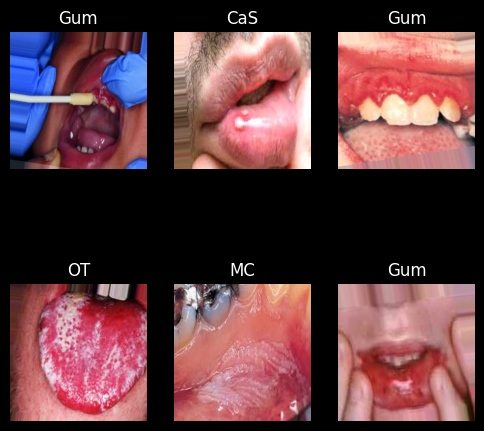

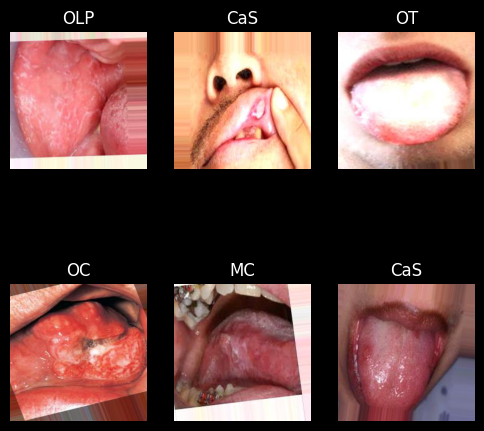

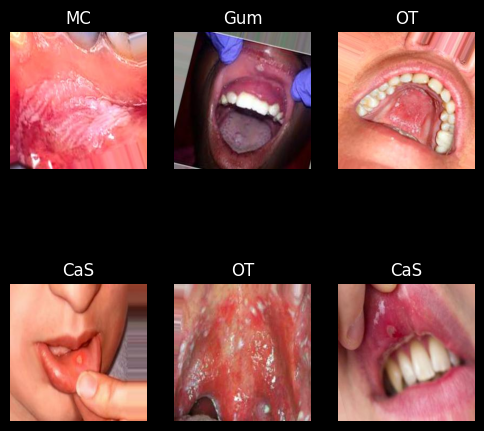

In [14]:
def plot_after_preparring(Cat_images,Cat_labels):
  plt.figure(figsize=(6,6))
  for index in range(6):
    random_index=random.randint(0,len(Cat_images))
    plt.subplot(2,3,index+1)
    plt.imshow(Cat_images[random_index])
    plt.title(Illness[Cat_labels[random_index]])
    plt.axis('off')
  plt.show()

plot_after_preparring(train_images,train_labels)
plot_after_preparring(test_images,test_labels)
plot_after_preparring(val_images,val_labels)

# **_Scalling our Data_**

In [27]:
def scale_images_in_batches(images, batch_size):
    num_images = len(images)
    scaled_images = []
    
    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        batch = np.array(images[start:end]) / 255.0
        scaled_images.append(batch)
    
    return np.concatenate(scaled_images, axis=0)

# Define a batch size that fits your memory constraints
batch_size = 200

train_images_scaled = scale_images_in_batches(train_images, batch_size)
test_images_scaled = scale_images_in_batches(test_images, batch_size)
val_images_scaled = scale_images_in_batches(val_images, batch_size)



In [15]:
def scale_and_resize_images_in_batches(images, batch_size, target_size):
    num_images = len(images)
    scaled_images = []
    
    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        batch = np.array(images[start:end])
        
        # Resize images
        batch_resized = tf.image.resize(batch, target_size)
        
        # Scale images
        batch_scaled = batch_resized / 255.0
        
        scaled_images.append(batch_scaled)
    
    return np.concatenate(scaled_images, axis=0)

# Define a batch size that fits your memory constraints
batch_size = 200
target_size = (128, 128)  # or (128, 128) if desired

# Apply scaling and resizing
train_images_scaled = scale_and_resize_images_in_batches(train_images, batch_size, target_size)
test_images_scaled = scale_and_resize_images_in_batches(test_images, batch_size, target_size)
val_images_scaled = scale_and_resize_images_in_batches(val_images, batch_size, target_size)

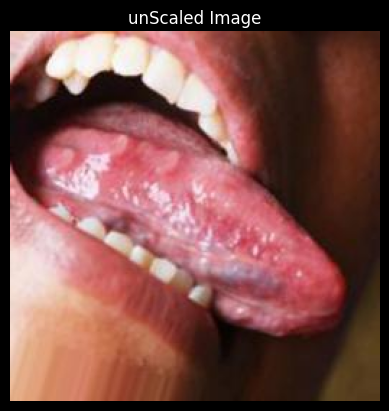

In [16]:
plt.imshow(train_images[0])
plt.title("unScaled Image")
plt.axis('off')  # Turn off axis for better view
plt.show()

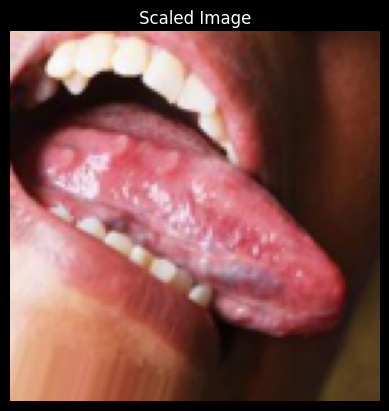

In [17]:
plt.imshow(train_images_scaled[0])
plt.title("Scaled Image")
plt.axis('off')  # Turn off axis for better view
plt.show()

In [18]:
# Find max and min values
train_max = np.max(train_images)
train_min = np.min(train_images)

test_max = np.max(test_images)
test_min = np.min(test_images)

val_max = np.max(val_images)
val_min = np.min(val_images)

print(f"Training Data - Max: {train_max}, Min: {train_min}")
print(f"Testing Data - Max: {test_max}, Min: {test_min}")
print(f"Validation Data - Max: {val_max}, Min: {val_min}")

Training Data - Max: 255, Min: 0
Testing Data - Max: 255, Min: 0
Validation Data - Max: 255, Min: 0


In [19]:
# Find max and min values
train_max = np.max(train_images_scaled)
train_min = np.min(train_images_scaled)

test_max = np.max(test_images_scaled)
test_min = np.min(test_images_scaled)

val_max = np.max(val_images_scaled)
val_min = np.min(val_images_scaled)

print(f"Training Data - Max: {train_max}, Min: {train_min}")
print(f"Testing Data - Max: {test_max}, Min: {test_min}")
print(f"Validation Data - Max: {val_max}, Min: {val_min}")

Training Data - Max: 1.0, Min: 0.0
Testing Data - Max: 1.0, Min: 0.0
Validation Data - Max: 1.0, Min: 0.0


# **_Modeling part_**

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
model=Sequential()

In [21]:
def build_model():
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(filters=32,
                     kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
################################################
    model.add(Conv2D(filters=64,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
################################################
    model.add(Conv2D(filters=128,
                     kernel_size=(3, 3),
                     activation='relu'))
    model.add(BatchNormalization())   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
################################################
    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(units=128,
                    activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
       
################################################

    model.add(Dense(7, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [22]:
model=build_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,951 (12.62 MB)

 Trainable params: 3,306,247 (12.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [24]:
train_labels_scaled = np.array(train_labels)
val_labels_scaled = np.array(val_labels)
test_labels_scaled = np.array(test_labels)
print("Type of train_images_scaled:", type(train_images_scaled))
print("Type of val_images_scaled:", type(val_images_scaled))
print("Type of test_images_scaled:", type(test_images_scaled))
print("Type of train_labels:", type(train_labels_scaled))
print("Type of val_labels:", type(val_labels_scaled))
print("Type of test_labels:", type(test_labels_scaled))

Type of train_images_scaled: <class 'numpy.ndarray'>
Type of val_images_scaled: <class 'numpy.ndarray'>
Type of test_images_scaled: <class 'numpy.ndarray'>
Type of train_labels: <class 'numpy.ndarray'>
Type of val_labels: <class 'numpy.ndarray'>
Type of test_labels: <class 'numpy.ndarray'>


In [25]:
# Print the shape of your input data
print(train_images_scaled.shape)
print(test_images_scaled.shape)
print(val_images_scaled.shape)

(3087, 128, 128, 3)
(1028, 128, 128, 3)
(1028, 128, 128, 3)


In [26]:
train_images_scaled = train_images_scaled.astype('float32')
test_images_scaled = test_images_scaled.astype('float32')
val_images_scaled = val_images_scaled.astype('float32')


In [27]:
print(f"Training Images Shape: {train_images_scaled.shape}")
print(f"Training Labels Shape: {train_labels_scaled.shape}")
print(f"Validation Images Shape: {val_images_scaled.shape}")
print(f"Validation Labels Shape: {val_labels_scaled.shape}")

# Check data types
print(f"Training Images Data Type: {train_images_scaled.dtype}")
print(f"Training Labels Data Type: {train_labels_scaled.dtype}")

Training Images Shape: (3087, 128, 128, 3)
Training Labels Shape: (3087,)
Validation Images Shape: (1028, 128, 128, 3)
Validation Labels Shape: (1028,)
Training Images Data Type: float32
Training Labels Data Type: int64


In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_scaled, train_labels_scaled))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images_scaled, val_labels_scaled))

batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [48]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping to stop training when validation loss is not improving
early_stopping = EarlyStopping(patience=5)

# ReduceLROnPlateau to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, min_lr=0.00001)

# Fit the model
model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=[early_stopping, reduce_lr])


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 435s 4s/step - accuracy: 0.2204 - loss: 2.4938 - val_accuracy: 0.1761 - val_loss: 3.3932 - learning_rate: 0.0010
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


97/97 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step - accuracy: 0.3643 - loss: 1.8307 - val_accuracy: 0.2626 - val_loss: 3.6529 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 424s 4s/step - accuracy: 0.4450 - loss: 1.5414 - val_accuracy: 0.2461 - val_loss: 3.3524 - learning_rate: 0.0010
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.5029 - loss: 1.3528 - val_accuracy: 0.3317 - val_loss: 2.3579 - learning_rate: 0.0010
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 426s 4s/step - accuracy: 0.5881 - loss: 1.1212 - val_accuracy: 0.2938 - val_loss: 2.7370 - learning_rate: 0.0010
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 439s 4s/step - accuracy: 0.6927 - loss: 0.9017 - val_accuracy: 0.3842 - val_loss: 2.1198 - learning_rate: 0.0010
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 425s 4s/step - accuracy: 0.7555 - loss: 0.7178 - val_accuracy: 0.3852 - val_loss: 1.9413 - learning_rate: 0.0010
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 422s 4s/step - accuracy: 0.7283 - loss: 0.7810 - val_accuracy: 0.45

In [49]:
val_loss, val_accuracy = model.evaluate(val_images_scaled, val_labels_scaled)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 752ms/step - accuracy: 0.5069 - loss: 1.4598
Validation Loss: 1.4940768480300903
Validation Accuracy: 0.5097275972366333


In [50]:
test_loss, test_accuracy = model.evaluate(test_images_scaled, test_labels_scaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 758ms/step - accuracy: 0.5489 - loss: 1.3733
Test Loss: 1.5054717063903809
Test Accuracy: 0.5068093538284302


# Model 2

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Create in-memory data augmentation streams using ImageDataGenerator.flow()
train_generator = datagen.flow(
    train_images_scaled,  # Your preprocessed training images
    train_labels_scaled,  # Your preprocessed training labels
    batch_size=32,
    shuffle=True,  # Shuffle data for each epoch
    seed=None  # Optional seed for reproducibility
)

val_generator = datagen.flow(
    val_images_scaled,  # Your preprocessed validation images
    val_labels_scaled,  # Your preprocessed validation labels
    batch_size=32,
    shuffle=False  # No shuffling for validation data
)

# Early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate on plateau to prevent stagnation
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-5)

# Fit the model using the augmented data generators
history_model = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 96s 977ms/step - accuracy: 0.2988 - loss: 1.9700 - val_accuracy: 0.2267 - val_loss: 3.3319 - learning_rate: 0.0010
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 95s 973ms/step - accuracy: 0.3505 - loss: 1.7707 - val_accuracy: 0.1449 - val_loss: 4.6489 - learning_rate: 0.0010
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 95s 969ms/step - accuracy: 0.4170 - loss: 1.5830 - val_accuracy: 0.1508 - val_loss: 5.5032 - learning_rate: 0.0010
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 95s 973ms/step - accuracy: 0.4312 - loss: 1.5638 - val_accuracy: 0.1926 - val_loss: 3.5719 - learning_rate: 5.0000e-04
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 142s 972ms/step - accuracy: 0.4674 - loss: 1.4308 - val_accuracy: 0.3142 - val_loss: 1.9524 - learning_rate: 5.0000e-04
Epoch 6/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 95s 969ms/step - accuracy: 0.4925 - loss: 1.3804 - val_accuracy: 0.2840 - val_loss: 2.0377 - learning_rate: 5.0000e-04
Epoch 7/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 95s 968ms/step - accuracy: 0.47

In [31]:
val_loss, val_accuracy = model.evaluate(val_images_scaled, val_labels_scaled)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 0.6418 - loss: 0.9790
Validation Loss: 0.932053804397583
Validation Accuracy: 0.6566147804260254


In [32]:
test_loss, test_accuracy = model.evaluate(test_images_scaled, test_labels_scaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.6415 - loss: 0.9855
Test Loss: 0.962643563747406
Test Accuracy: 0.6478599309921265


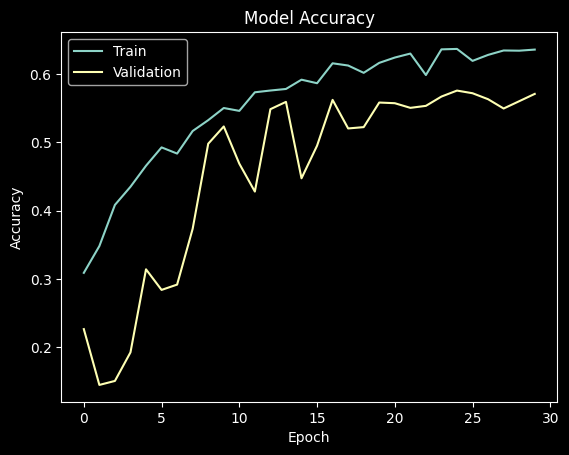

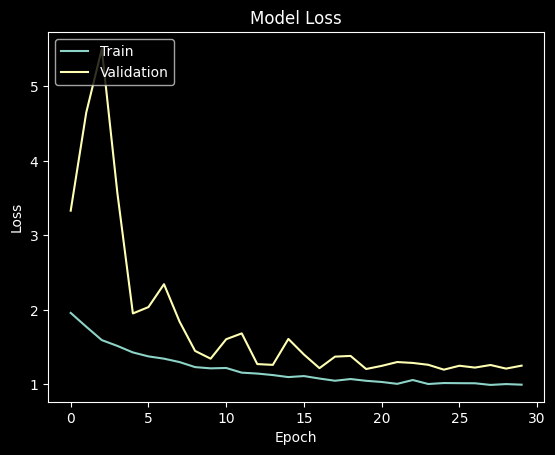

In [35]:
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

model4


Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.2344 - loss: 3.2245 - val_accuracy: 0.1459 - val_loss: 4.1568 - learning_rate: 0.0010
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.2991 - loss: 2.7682 - val_accuracy: 0.1946 - val_loss: 5.2083 - learning_rate: 0.0010
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.3568 - loss: 2.5058 - val_accuracy: 0.2004 - val_loss: 5.5402 - learning_rate: 0.0010
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.3792 - loss: 2.3104 - val_accuracy: 0.1984 - val_loss: 5.8436 - learning_rate: 0.0010
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.4273 - loss: 2.1694 - val_accuracy: 0.2179 - val_loss: 3.8692 - learning_rate: 0.0010
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.4578 - loss: 2.0429 - val_accuracy: 0.2870 - val_loss: 3.5811 - learning_rate: 0.0010
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5053 - loss: 1.9275 - val_acc

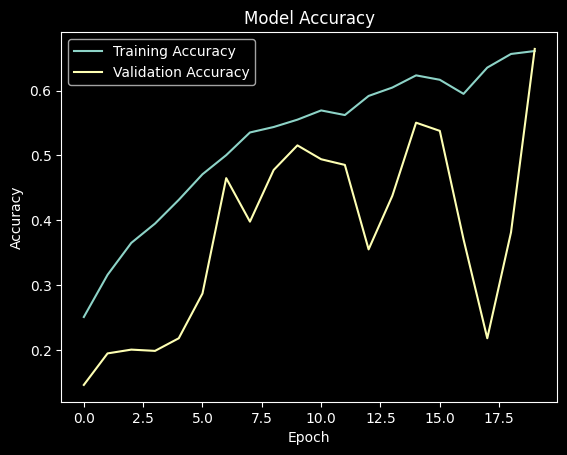

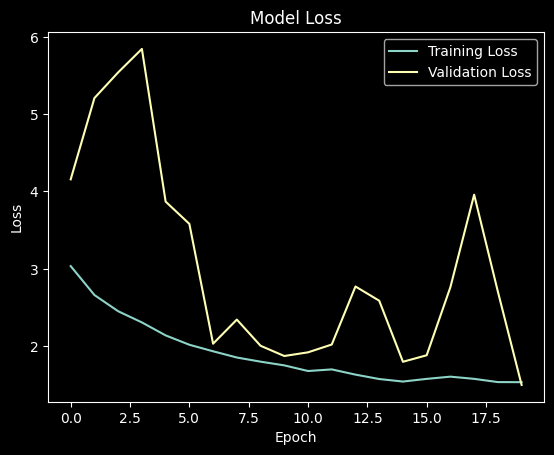

In [52]:
from tensorflow.keras.regularizers import l2

def build_model():
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    # Flatten and Dense layers
    model.add(Flatten())
    
    model.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
       
    model.add(Dense(units=7, activation='softmax'))  # Assuming 7 classes
    
    # Compile model with a different optimizer
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Build the updated model
model2 = build_model()

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Create in-memory data augmentation streams using ImageDataGenerator.flow()
train_generator = datagen.flow(
    train_images_scaled,  # Your preprocessed training images
    train_labels_scaled,  # Your preprocessed training labels
    batch_size=32,
    shuffle=True,  # Shuffle data for each epoch
    seed=None  # Optional seed for reproducibility
)

val_generator = datagen.flow(
    val_images_scaled,  # Your preprocessed validation images
    val_labels_scaled,  # Your preprocessed validation labels
    batch_size=32,
    shuffle=False  # No shuffling for validation data
)
# Updated training parameters
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with more epochs
historym = model2.fit(
    train_generator,
    epochs=20,  # Increased number of epochs
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Plotting the results
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(historym.history['accuracy'], label='Training Accuracy')
plt.plot(historym.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss plot
plt.plot(historym.history['loss'], label='Training Loss')
plt.plot(historym.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [54]:
val_loss, val_accuracy = model2.evaluate(val_images_scaled, val_labels_scaled)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

test_loss, test_accuracy = model2.evaluate(test_images_scaled, test_labels_scaled)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.7302 - loss: 1.3525
Validation Loss: 1.3523496389389038
Validation Accuracy: 0.7276264429092407
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.7091 - loss: 1.3979
Test Loss: 1.387321949005127
Test Accuracy: 0.7130350470542908
